# Investigation of time related features in Bikesharing system dataset 
## by Boris Kushnarev 

## Investigation overview
> The dataset Ford GoBike System Data has been investigated. Main features have been defined related to time such as duration of bike ride, hour of the day and day of a week when bikes are taken for a ride as well as relationships were found with other features. 

## Dataset overview

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. This dataset can be downloaded followin this [link](https://drive.google.com/file/d/1gsg4DPGEyyjharedDMKTb6WOhEmOrsfs/view?usp=sharing). 


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import datetime
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
#laod data from a .csv file
df = pd.read_csv('../2017-fordgobike-tripdata.csv')

In [4]:
#perform some data cleaning
df = df.dropna() #drop rows with missing values
#drop unused cloumns 
df = df.drop(['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude', 
              'bike_id', 'start_station_id', 'end_station_id', 'user_type' ], axis=1)
#make member_birth_year int
df.member_birth_year=df.member_birth_year.astype('int64')
df.start_time = pd.to_datetime(df.start_time) #string to datatime
df.end_time = pd.to_datetime(df.end_time) #string to datatime

In [5]:
df['age'] = pd.DatetimeIndex(df['start_time']).year - df.member_birth_year #find age of the user
df['hour'] = pd.DatetimeIndex(df['start_time']).hour #hour of a day when bike is taken
df['dow'] = df.start_time.dt.dayofweek+1 #extract day of a week and "+1" makes Monday - 1, not 0
df.loc[df.hour == 0, 'hour'] = 24 #to avoid log(0) make 0 -> 24
df['duration_min'] = (df.duration_sec / 60).astype('int64') #add column - duration in minutes 
df=df.query('member_gender != "Other"') #consider Other as outlier
df.drop(['duration_sec', 'member_birth_year', 'start_time', 'end_time'], axis = 1, inplace=True)

# Distribution of time of the day when bikes are taken for a ride

An hourly histogram of the time of the day when bikes are more likely to be taken for a ride is plotted. We can see two modes at 8am and 5pm. We can assume that these hours correspond to the time when people are going to work or coming from work. The graph on log scale on x-axis just confirms the findings on real values.     

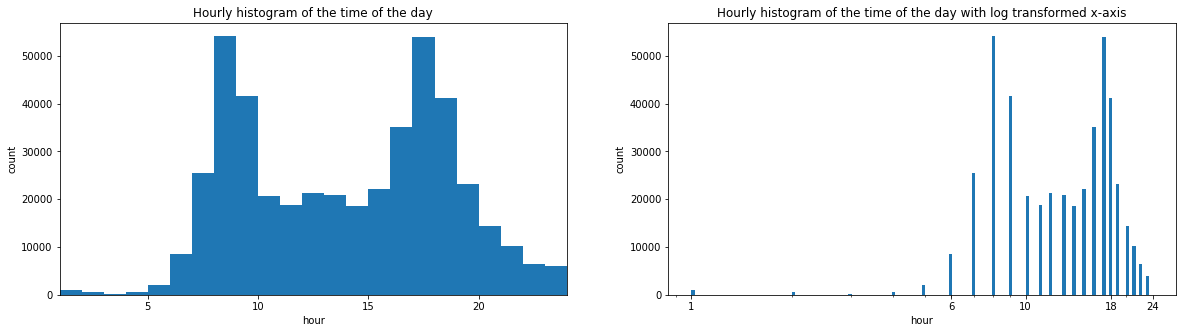

In [6]:
plt.figure(figsize = [20,5])

plt.subplot(1,2,1)
plt.xlim(1,24)
bin_edges = np.arange(0, df.hour.max()+1, 1)
sb.distplot(df.hour, kde=False, hist_kws ={'alpha':1}, bins = bin_edges);
plt.title('Hourly histogram of the time of the day');
plt.ylabel('count');
plt.xlabel('hour');

plt.subplot(1,2,2)
bin_edges = 10 ** np.arange(0, np.log10(df.hour.max()+0.1), 0.01)
sb.distplot(df.hour, kde=False, hist_kws ={'alpha':1} , bins = bin_edges); 
plt.xscale('log');
tick_locs = [1,6, 10, 18, 24];
plt.xticks(tick_locs, tick_locs);
plt.title('Hourly histogram of the time of the day with log transformed x-axis');
plt.ylabel('count');
plt.xlabel('hour');

# Demographic of riders   

Demographic aspects play importent role for further development of the Bike sharing system in San Francisco.  Age and gender distributions are plotted. We can see that the most popular bike sharing system among those who is about 32 year old. Moreover, the distribution is very right skewed. The gender distribution shows that males ride bikes 35 time more often than women. Hence, if we want to attrack more older clietns or women some strategy needs to be developed such as social media advertisement or 3 wheel bikes mmight be offered for olders people.  

In addition, the heatmap between year and gender is plotted. It gives us more information shared between age and gender. We can see that We can see that men between 31-35 use bikes most often, men between 26-30 years use bike a litle bit less. Women between 26-35 use bikes most often among women but about 2.5 times less than men at the age 31-35. The number of rides gradually decrease for men and women when they reach 76-80 years old.

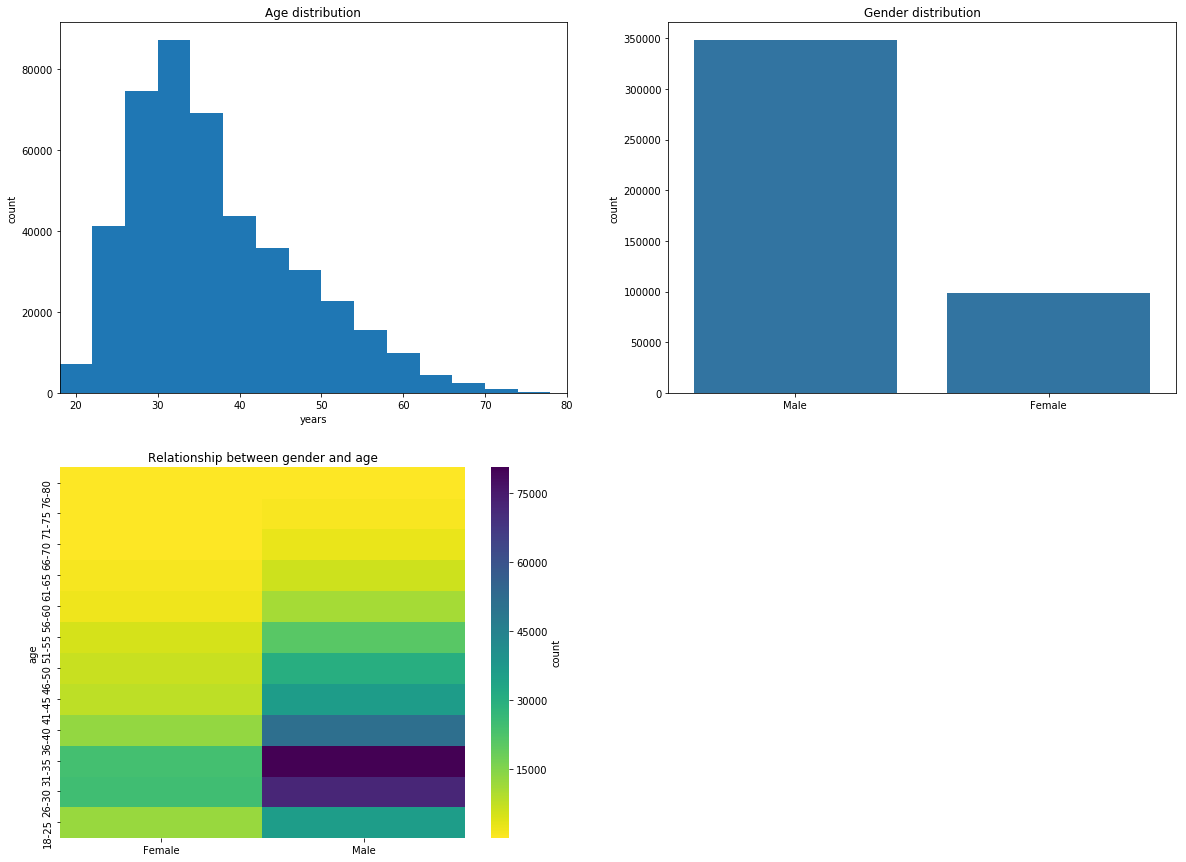

In [8]:
base_color = sb.color_palette()[0]
plt.figure(figsize = [20,15])

plt.subplot(2,2,1)
width = 4
bin_edges = np.arange(df.age.min(),  df.age.max()+width, width)
sb.distplot(df.age, kde=False, hist_kws ={'alpha':1}, bins = bin_edges);
plt.xlim(df.age.min(), 80); #there are some outliers: some of them above 80 and others close to 120, I believe it is possible but can be a mistake
plt.title('Age distribution');
plt.ylabel('count');
plt.xlabel('years');

plt.subplot(2,2,2)
sb.countplot(df.member_gender, color = base_color);
plt.title('Gender distribution');
plt.ylabel('count');
plt.xlabel('');

plt.subplot(2,2,3)
ct_counts =df.query('age < 80')
ct_counts['range'] = pd.cut(ct_counts.age, [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80], include_lowest=True,
                           labels = ['18-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', 
                                    '71-75', '76-80'])
ct_counts = ct_counts.groupby(['range', 'member_gender']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'range', columns = 'member_gender', values = 'count')
ax= sb.heatmap(ct_counts, cmap = 'viridis_r', cbar_kws = {'label' : 'count'},)
ax.invert_yaxis();
plt.title('Relationship between gender and age');
plt.xlabel('');
plt.ylabel('age');

# Most popular routes and duration between stations

4 most popular starting stations and correspong 4 most popular arrival stations were defined. The bar chart for these routes was plotted. It shows that the route # 9 which is between San Francisco Ferry Building station and Montgomery St BART Station is the most popular. The mapping between # of routes and stations will be shown after the plots.

In addition to this plot a violin plot of duration for each popular route is shown. We can see that the routes # 1 and # 5 takes more time with medians about 18 mins. Routes 12 and 13 have no distributions shown and it can be because of distributions are too narrow.

In [9]:
idx1 = df.start_station_name.value_counts().index[0:4]
df_often = df.loc[df['start_station_name'].isin(idx1)]
idx2=df_often.end_station_name.value_counts().index[0:4]
df_often=df.loc[df['end_station_name'].isin(idx2)]
k = 1
df_often['route'] = 0
mapping_list = []
for i in idx1:
    for j in idx2:
        df_often.loc[(df_often['start_station_name']==i) & (df_often['end_station_name']==j), 'route'] = k
        mapping_list.append({'route' : k,
                       'start_station_name': i,
                      'end_station_name' : j})
        k+=1
mapping_df = pd.DataFrame(mapping_list, columns = ['route', 'start_station_name', 'end_station_name'])        
df_often = df_often.query('route != 0') #remove values which don't correspond to any routes between stations
df_often.route= df_often.route.astype('category') 

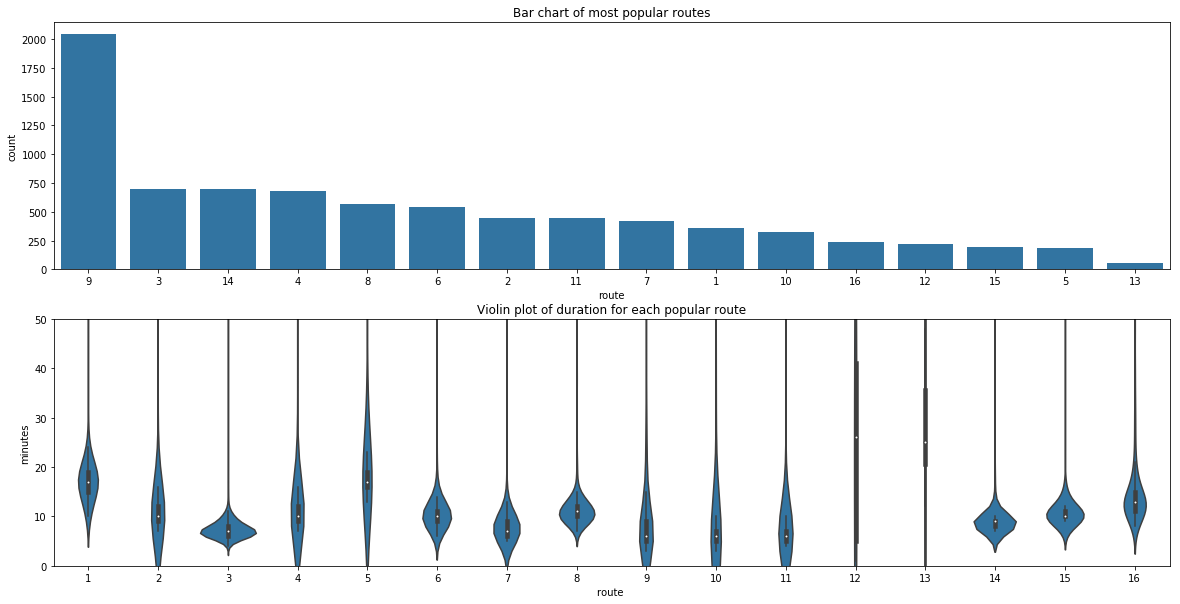

In [10]:
plt.figure(figsize = [20,10])

plt.subplot(2,1,1)
cat_order = df_often.route.value_counts().index
sb.countplot(df_often.route, color = base_color, order = cat_order);
plt.title('Bar chart of most popular routes')

plt.subplot(2,1,2)
sb.violinplot(data = df_often, x = df_often.route, y = df_often.duration_min, color = base_color )
plt.ylim(0,50)
plt.title('Violin plot of duration for each popular route');
plt.xlabel('route ');
plt.ylabel('minutes');

In [11]:
mapping_df

,route,start_station_name,end_station_name
0,1,San Francisco Caltrain (Townsend St at 4th St),The Embarcadero at Sansome St
1,2,San Francisco Caltrain (Townsend St at 4th St),Montgomery St BART Station (Market St at 2nd St)
2,3,San Francisco Caltrain (Townsend St at 4th St),Howard St at 2nd St
3,4,San Francisco Caltrain (Townsend St at 4th St),San Francisco Ferry Building (Harry Bridges Pl...
4,5,San Francisco Caltrain Station 2 (Townsend St...,The Embarcadero at Sansome St
5,6,San Francisco Caltrain Station 2 (Townsend St...,Montgomery St BART Station (Market St at 2nd St)
6,7,San Francisco Caltrain Station 2 (Townsend St...,Howard St at 2nd St
7,8,San Francisco Caltrain Station 2 (Townsend St...,San Francisco Ferry Building (Harry Bridges Pl...
8,9,San Francisco Ferry Building (Harry Bridges Pl...,The Embarcadero at Sansome St
9,10,San Francisco Ferry Building (Harry Bridges Pl...,Montgomery St BART Station (Market St at 2nd St)


# Duration facetgrid splitted by day of the week

FacetGrid for the distribution of the duration on a log scale is plotted. We can see that during the weekdays the distributions mimic each other. The most common durations are 5 minutes and 13 minutes. We can see that shapes of distributions are similar but the number of rides is significantly lower on weekends than on weekdays.  


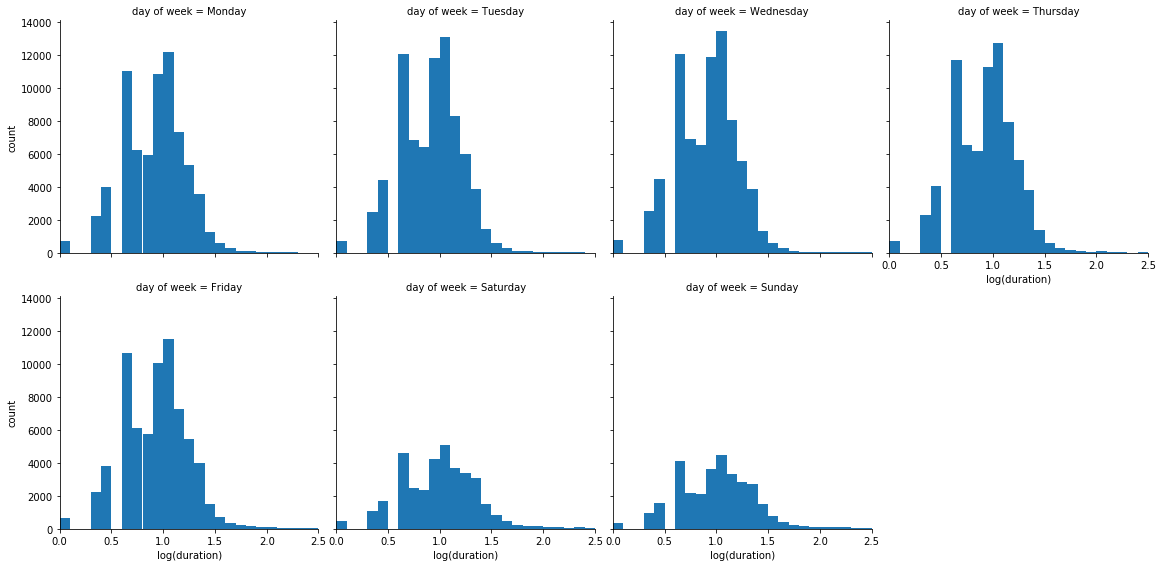

In [21]:
#Let's define categorical variable for dow
df["day of week"] = np.nan
df.loc[df.dow == 1, "day of week" ] = "Monday"
df.loc[df.dow == 2, "day of week" ] = "Tuesday"
df.loc[df.dow == 3, "day of week" ] = "Wednesday"
df.loc[df.dow == 4, "day of week" ] = "Thursday"
df.loc[df.dow == 5, "day of week" ] = "Friday"
df.loc[df.dow == 6, "day of week" ] = "Saturday"
df.loc[df.dow == 7, "day of week" ] = "Sunday"

ordinal_var_dict = {"day of week": ['Monday','Tuesday','Wednesday','Thursday','Friday', "Saturday", "Sunday"]}
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict["day of week"] )
df["day of week"] = df["day of week"].astype(ordered_var)

df['log_duration'] = np.log10(df.duration_min)
bin_edges = bin_edges = np.arange(0, np.log10(df.duration_min.max()+0.1), 0.1)
g = sb.FacetGrid(data=df, col = 'day of week',  margin_titles = True, col_wrap= 4 , height =4); 
g.map(sb.distplot, 'log_duration', kde=False, bins = bin_edges, hist_kws ={'alpha':1}).set(xlim=(0,2.5));
g.set_xlabels("log(duration)");
g.set_ylabels('count');                          

# Dependance of the duration mean value 

In addition to the previous plot we will consider average duration time depending on the day of the week clustered by a gender. From the plot we can see that from Monday through Friday the average time of bike usage is about 15 minutes for women and about 12 minutes for men. On Saturaday and Sunday it is between 16-17 minutes for men and 23 minutes for women even though the number of rides on weekends is significantly lower. At the same time, we need to keep in mind that men 35 times more use the bike share system than women.  

In addition, the heatmap below shows that on everage women ride bikes longer than men. The longest average time belonges to women at 61-65 year old. Men use bikes pretty much uniformly through out the age 26 and 70, starting since 71 this number increasing. 

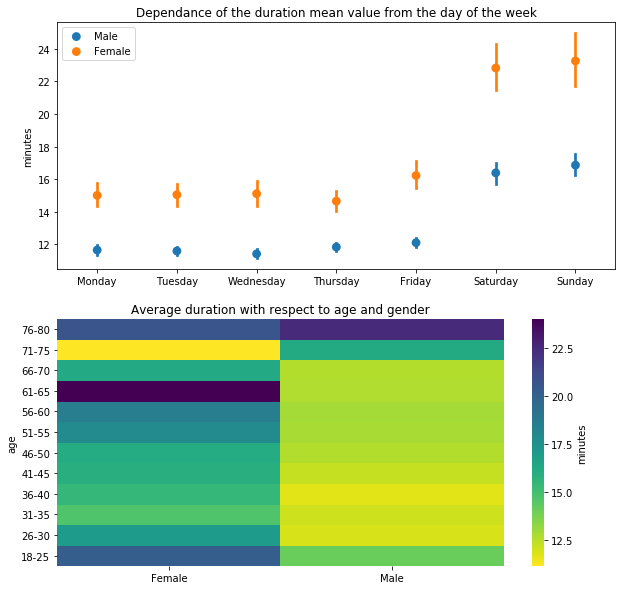

In [13]:
plt.figure(figsize=[10,10])

plt.subplot(2,1,1)
ax = sb.pointplot(data = df, x = 'dow', y = 'duration_min', hue = 'member_gender', linestyles="");
ax.legend(loc = 8, ncol = 3, framealpha = 1, title = 'gender');
tick_locs = ["Monday", "Tuesday", 'Wednesday', 'Thursday', "Friday", 'Saturday', "Sunday"];
plt.xticks([0, 1,2,3,4,5,6], tick_locs);
plt.xlabel('');
plt.ylabel('minutes');
plt.legend(loc=2);
plt.title('Dependance of the duration mean value from the day of the week');

cat_means=df.query('age<80')
cat_means['range'] = pd.cut(cat_means.age, [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80], include_lowest=True,
                           labels = ['18-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', 
                                    '71-75', '76-80'])

plt.subplot(2,1,2)
cat_means = cat_means.groupby(['range', 'member_gender']).mean()['duration_min']
cat_means = cat_means.reset_index(name = 'duration_mean')


cat_means = cat_means.pivot(index = 'range', columns = 'member_gender',
                            values = 'duration_mean')



ax = sb.heatmap(cat_means, annot = False, cbar_kws = {'label' : 'minutes'}, cmap = 'viridis_r')
ax.invert_yaxis();

plt.title('Average duration with respect to age and gender')
plt.xlabel('')
plt.ylabel('age')

# Heatmap between hour of the day and day of the week

Heatmap between hour of the day and day of the week is plotted. We can see that bikes are normally taken in between 6am and 9pm on weekends. 8am and 5pm are the most popular time when bikes are taken for rides on weekdays because people are going to work and coming from work at this time. On weekends the heatmap does not have any extreme values and shows that time when bikes are taken is between 10am and 7pm and number of rides uniformly distributed in this period.

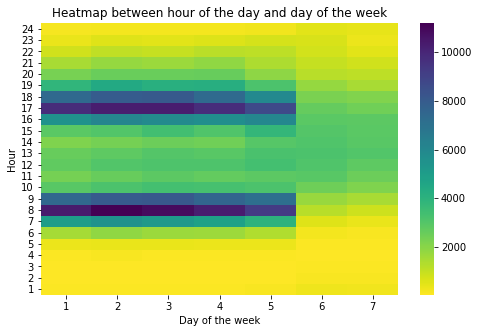

In [14]:
#let's prepare data for heatmap
ct_counts = df.groupby(['hour', 'dow']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts =ct_counts.pivot(index = 'hour', columns = 'dow', values = 'count')
ct_counts.fillna(0, inplace=True)

plt.figure(figsize = [8,5])
ax = sb.heatmap(ct_counts, cmap = 'viridis_r');
ax.invert_yaxis();
plt.title('Heatmap between hour of the day and day of the week');
plt.xlabel('Day of the week');
plt.ylabel('Hour');


# Average duration time with respect to age and gender

The heatmap below shows that on everage women ride bikes longer than men. The longest average time belonges to women at 61-65 year old while men use bikes 35 times more often as it was shown above. Between 35 and 70 year old man duration time is almost uniform about 13 minutes and only at 71 it starts increasing and reaches it's maximum when men ar 75-80. On the other hand we need to keep in mind that at this age people do not use bikes often.  

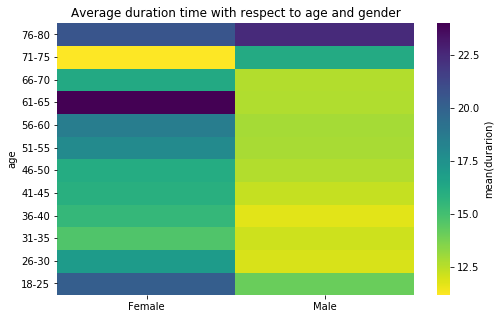

In [19]:
plt.figure(figsize=[8,5]);
cat_means=df.query('age<80')
cat_means['range'] = pd.cut(cat_means.age, [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80], include_lowest=True,
                           labels = ['18-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', 
                                    '71-75', '76-80'])


cat_means = cat_means.groupby(['range', 'member_gender']).mean()['duration_min']
cat_means = cat_means.reset_index(name = 'duration_mean')


cat_means = cat_means.pivot(index = 'range', columns = 'member_gender',
                            values = 'duration_mean')



ax = sb.heatmap(cat_means, annot = False, cbar_kws = {'label' : 'mean(durarion)'}, cmap = 'viridis_r');
ax.invert_yaxis();
plt.title('Average duration time with respect to age and gender')
plt.xlabel('');
plt.ylabel('age');